Preprocessing Audio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import librosa
import numpy as np
import scipy.signal as signal
import soundfile as sf
from tqdm import tqdm

input_root = "/content/drive/MyDrive/detector/dataset"
output_root = "/content/drive/MyDrive/detector/cleaned_audio_dataset"

def trim_silence(audio, top_db=25):
    return librosa.effects.trim(audio, top_db=top_db)[0]

def time_shift(audio, shift_max=0.2):
    shift = int(np.random.uniform(-shift_max, shift_max) * len(audio))
    return np.roll(audio, shift)

def pitch_shift(audio, sr, n_steps=2):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def bandpass_filter(audio, sr, lowcut=300, highcut=8000):
    nyquist = 0.5 * sr
    b, a = signal.butter(2, [lowcut / nyquist, highcut / nyquist], btype='band')
    return signal.lfilter(b, a, audio)

def normalize(audio):
    max_val = np.max(np.abs(audio))
    return audio if max_val == 0 else audio / max_val

def preprocess_audio(audio, sr, augment_type=None):
    try:
        audio = trim_silence(audio)
        audio = bandpass_filter(audio, sr)
        audio = normalize(audio)

        if augment_type == "shift":
            audio = time_shift(audio)
        elif augment_type == "pitch":
            audio = pitch_shift(audio, sr)

        if not np.isfinite(audio).all():
            raise ValueError("Non-finite value in audio after processing")

        return audio
    except Exception as e:
        print(f"⚠️ Skipping audio due to error: {e}")
        return None

def split_audio(audio, sr, chunk_duration=5.0):
    chunk_samples = int(chunk_duration * sr)
    return [audio[i:i+chunk_samples] for i in range(0, len(audio), chunk_samples) if len(audio[i:i+chunk_samples]) == chunk_samples]

augment_types = [None, 'shift', 'pitch']

for subdir, dirs, files in os.walk(input_root):
    for file in tqdm(files, desc=f"🔄 Preprocessing {subdir}"):
        if file.endswith(".wav"):
            file_path = os.path.join(subdir, file)
            y, sr = librosa.load(file_path, sr=22050)
            chunks = split_audio(y, sr, chunk_duration=5.0)

            for i, chunk in enumerate(chunks):
                for aug in augment_types:
                    y_processed = preprocess_audio(chunk, sr, augment_type=aug)

                    if y_processed is None:
                        continue

                    suffix = f"_chunk{i}_{aug}" if aug else f"_chunk{i}"
                    filename = os.path.splitext(file)[0] + f"{suffix}.wav"

                    relative_path = os.path.relpath(subdir, input_root)
                    output_folder = os.path.join(output_root, relative_path)
                    os.makedirs(output_folder, exist_ok=True)

                    output_path = os.path.join(output_folder, filename)
                    sf.write(output_path, y_processed, sr)

print("✅ Semua file audio berhasil dipotong, dibersihkan, dan disimpan di:", output_root)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


🔄 Preprocessing /content/drive/MyDrive/detector/dataset: 0it [00:00, ?it/s]
🔄 Preprocessing /content/drive/MyDrive/detector/dataset/non_chainsaw: 100%|██████████| 148/148 [00:21<00:00,  6.77it/s]
🔄 Preprocessing /content/drive/MyDrive/detector/dataset/chainsaw: 100%|██████████| 76/76 [02:50<00:00,  2.25s/it]

✅ Semua file audio berhasil dipotong, dibersihkan, dan disimpan di: /content/drive/MyDrive/detector/cleaned_audio_dataset


Segmenting Audio

In [ ]:
import os
import librosa
import soundfile as sf
from tqdm import tqdm

input_root = "/content/drive/MyDrive/detector/cleaned_audio_dataset"
output_root = "/content/drive/MyDrive/detector/segmented_audio_dataset"
segment_duration = 5

def segment_audio(audio, sr, segment_duration):
    segment_length = int(sr * segment_duration)
    total_segments = len(audio) // segment_length
    segments = [audio[i*segment_length:(i+1)*segment_length] for i in range(total_segments)]
    return segments

for subdir, _, files in os.walk(input_root):
    for file in tqdm(files, desc=f"📎 Segmenting {subdir}"):
        if file.endswith(".wav"):
            file_path = os.path.join(subdir, file)
            y, sr = librosa.load(file_path, sr=22050)

            segments = segment_audio(y, sr, segment_duration)
            label = os.path.basename(subdir)
            output_folder = os.path.join(output_root, label)
            os.makedirs(output_folder, exist_ok=True)

            for i, segment in enumerate(segments):
                output_filename = f"{os.path.splitext(file)[0]}_seg{i}.wav"
                output_path = os.path.join(output_folder, output_filename)
                sf.write(output_path, segment, sr)

print("✅ Semua file berhasil dipotong dan disimpan ke folder segmented.")

📎 Segmenting /content/drive/MyDrive/detector/cleaned_audio_dataset: 0it [00:00, ?it/s]
📎 Segmenting /content/drive/MyDrive/detector/cleaned_audio_dataset/non_chainsaw: 100%|██████████| 444/444 [00:11<00:00, 40.02it/s]
📎 Segmenting /content/drive/MyDrive/detector/cleaned_audio_dataset/chainsaw: 100%|██████████| 2931/2931 [01:51<00:00, 26.29it/s]

✅ Semua file berhasil dipotong dan disimpan ke folder segmented.


Extracting MCFF

In [ ]:
import os
import librosa
import numpy as np
from tqdm import tqdm

input_root = "/content/drive/MyDrive/detector/segmented_audio_dataset"

n_mfcc = 13
sr = 22050
max_pad_len = 216

X = []
y = []

for label in ['chainsaw', 'non_chainsaw']:
    folder_path = os.path.join(input_root, label)
    for file in tqdm(os.listdir(folder_path), desc=f"🎵 Extracting MFCC for {label}"):
        if file.endswith('.wav'):
            file_path = os.path.join(folder_path, file)
            audio, _ = librosa.load(file_path, sr=sr)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

            if mfcc.shape[1] < max_pad_len:
                pad_width = max_pad_len - mfcc.shape[1]
                mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
            else:
                mfcc = mfcc[:, :max_pad_len]

            X.append(mfcc)
            y.append(1 if label == 'chainsaw' else 0)

X = np.array(X)
y = np.array(y)

print("✅ Shape Fitur MFCC:", X.shape)
print("✅ Shape Label:", y.shape)

np.save('/content/drive/MyDrive/detector/X_mfcc.npy', X)
np.save('/content/drive/MyDrive/detector/y_mfcc.npy', y)

print("✅ Dataset MFCC berhasil disimpan ke Google Drive!")

🎵 Extracting MFCC for non_chainsaw: 100%|██████████| 276/276 [00:12<00:00, 22.21it/s]


✅ Shape Fitur MFCC: (2949, 13, 216)
✅ Shape Label: (2949,)
✅ Dataset MFCC berhasil disimpan ke Google Drive!


Build CNN Model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - accuracy: 0.8318 - loss: 0.8007 - val_accuracy: 0.8864 - val_loss: 0.2735
Epoch 2/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.9020 - loss: 0.2666 - val_accuracy: 0.9220 - val_loss: 0.1690
Epoch 3/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.9146 - loss: 0.2343 - val_accuracy: 0.9085 - val_loss: 0.2475
Epoch 4/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.9352 - loss: 0.1716 - val_accuracy: 0.9254 - val_loss: 0.1792
Epoch 5/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.9408 - loss: 0.1631 - val_accuracy: 0.9576 - val_loss: 0.1296
Epoch 6/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.9515 - loss: 0.1418 - val_accuracy: 0.9288 - val_loss: 0.1617
Epoch 7/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.9495 - loss: 0.1224 - val_accuracy: 0.9424 - val_loss: 0.1319
Epoch 8/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.9545 - loss: 0.1579 - v

✅ Akurasi Model di Test Set: 95.25%


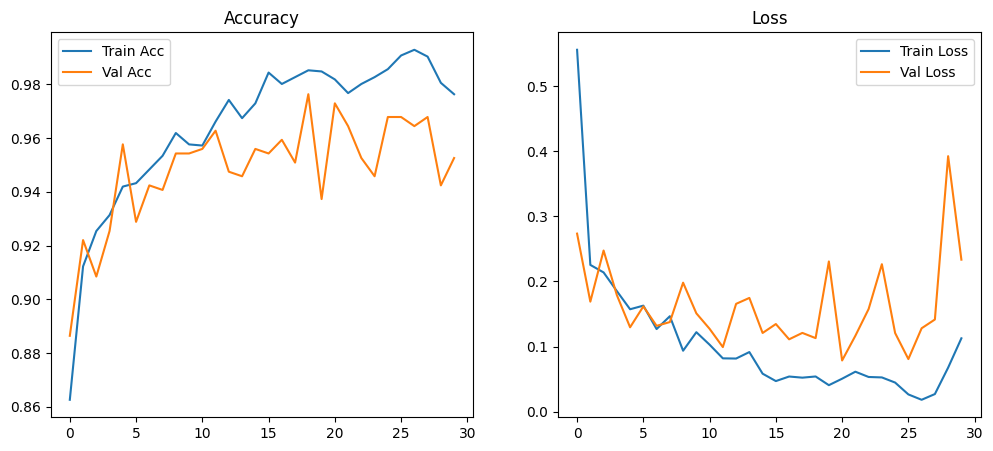

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

📊 Classification Report:
              precision    recall  f1-score   support

Non-Chainsaw       0.71      0.82      0.76        55
    Chainsaw       0.98      0.97      0.97       535

    accuracy                           0.95       590
   macro avg       0.85      0.89      0.87       590
weighted avg       0.96      0.95      0.95       590



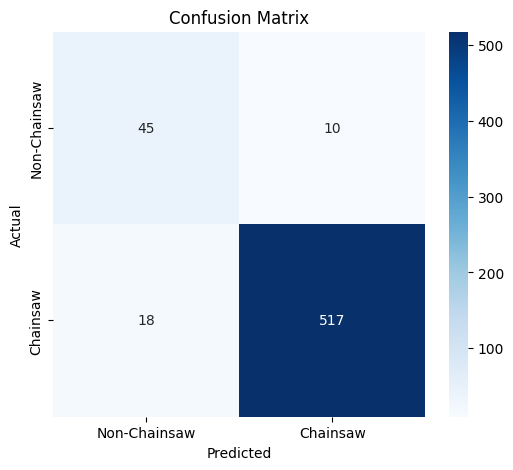

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import joblib

X = np.load('/content/drive/MyDrive/detector/X_mfcc.npy')
y = np.load('/content/drive/MyDrive/detector/y_mfcc.npy')

original_shape = X.shape
X_reshaped = X.reshape(X.shape[0], -1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)

joblib.dump(scaler, "/content/drive/MyDrive/detector/scaler.save")

X_scaled = X_scaled.reshape(original_shape)
X_scaled = X_scaled[..., np.newaxis]

y_cat = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cat, test_size=0.2, random_state=42, stratify=y)

model = Sequential([
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=X_scaled.shape[1:]),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=16,
                    validation_data=(X_test, y_test))

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"✅ Akurasi Model di Test Set: {test_acc * 100:.2f}%")

model.save("/content/drive/MyDrive/detector/cnn_chainsaw_model.h5")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.show()

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Chainsaw", "Chainsaw"]))

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Non-Chainsaw", "Chainsaw"],
            yticklabels=["Non-Chainsaw", "Chainsaw"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Convert .h5 to .tflite

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model("/content/drive/MyDrive/detector/cnn_chainsaw_model.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open("/content/drive/MyDrive/detector/cnn_chainsaw_model.tflite", 'wb') as f:
    f.write(tflite_model)

print("✅ Model berhasil dikonversi ke TFLite!")


Saved artifact at '/tmp/tmpcp2p_99k'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 13, 216, 1), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  136577726803664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136579382844432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136579382846160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136579382843856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136579382844048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136579382844816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136579382848080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136579382849616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136579382850576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136579382850192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13657938284539

In [ ]:
print("Input shape expected:", input_details[0]['shape'])

Input shape expected: [  1  13 216   1]


Predicting and Testing the Model

Saving 714073__lauri_lehtonen__motorcycle_9.wav to 714073__lauri_lehtonen__motorcycle_9.wav

📁 File uploaded: 714073__lauri_lehtonen__motorcycle_9.wav

✅ Predicted: Non-Chainsaw (Confidence: 0.98)


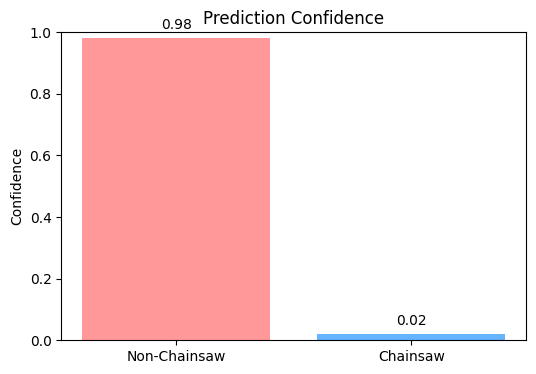

✅ Aman: Tidak ada chainsaw terdeteksi.


In [ ]:
import numpy as np
import librosa
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
from google.colab import files
import datetime
from sklearn.preprocessing import StandardScaler

uploaded = files.upload()
file_name = list(uploaded.keys())[0]
print(f"\n📁 File uploaded: {file_name}")

interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/detector/cnn_chainsaw_model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def preprocess_and_extract_mfcc(file_path):
    y, sr = librosa.load(file_path, sr=22050)
    y = librosa.util.fix_length(y, size=22050 * 5)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    mfcc_2d = mfcc.T

    if mfcc_2d.shape[0] != 216:
        mfcc_2d = mfcc_2d[:216]

    scaler = StandardScaler()
    mfcc_scaled = scaler.fit_transform(mfcc_2d)

    mfcc_scaled = mfcc_scaled.T
    return mfcc_scaled.reshape(1, 13, 216, 1).astype(np.float32)

def plot_prediction_confidence(labels, prediction):
    plt.figure(figsize=(6, 4))
    bars = plt.bar(labels, prediction, color=['#ff9999', '#66b3ff'])
    plt.ylim(0, 1)
    plt.title("Prediction Confidence")
    plt.ylabel("Confidence")

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

    plt.show()

def log_prediction_result(file_name, predicted_label, confidence):
    log_path = "/content/drive/MyDrive/detector/prediction_log.txt"
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    with open(log_path, 'a') as f:
        f.write(f"{timestamp} - {file_name} - {predicted_label} ({confidence:.2f})\n")

input_tensor = preprocess_and_extract_mfcc(file_name)
interpreter.set_tensor(input_details[0]['index'], input_tensor)
interpreter.invoke()
prediction = interpreter.get_tensor(output_details[0]['index'])[0]

labels = ['Non-Chainsaw', 'Chainsaw']
predicted_label = labels[np.argmax(prediction)]
confidence = np.max(prediction)

print(f"\n✅ Predicted: {predicted_label} (Confidence: {confidence:.2f})")
plot_prediction_confidence(labels, prediction)

log_prediction_result(file_name, predicted_label, confidence)

if predicted_label == 'Chainsaw':
    print("🚨 ALERT: Chainsaw detected!")
else:
    print("✅ Aman: Tidak ada chainsaw terdeteksi.")